# 2D Gaussian fitting
---

#### Overview
Walkthrough of how curve fitting is done in 2D using `scipy.optimize.curve_fit`

#### References
[1] https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

In [2]:
from psf_extractor import get_Daans_special_cmap

#### Select colormap

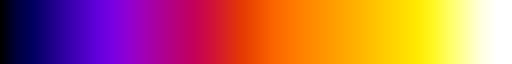

In [3]:
fire = get_Daans_special_cmap()
fire

#### 2D Gaussian function

In [4]:
def gaussian_2D(x, y, x0, y0, sigma_x, sigma_y, A, B):
    """2D Gaussian function with added background"""
    E = (x-x0)**2/(2*sigma_x**2) + (y-y0)**2/(2*sigma_y**2)
    return A * np.exp(-E) + B

#### Synthesize an image with a Gaussian blob

In [5]:
def nonwhite_noise(variance, shape):
    """Generate non-white (correlated) noise"""
    white = np.random.normal(0, 1, shape)
    correlated = gaussian_filter(white, .4)
    return np.sqrt(variance/correlated.var()) * correlated

In [6]:
Nx, Ny = 100, 100
x0 = np.random.uniform(0.2*Nx, 0.8*Nx, 1)
y0 = np.random.uniform(0.2*Ny, 0.8*Ny, 1)
sigma_x = np.random.uniform(Nx/30, Ny/10, 1)
sigma_y = np.random.uniform(Ny/30, Ny/10, 1)
A = np.random.uniform(1, 3, 1)
B = np.random.uniform(0, 1, 1)

# Create meshgrid for x, y data
xx, yy = np.meshgrid(np.arange(Nx), np.arange(Ny))
G = gaussian_2D(xx, yy, x0, y0, sigma_x, sigma_y, A, B)

# Add noise
var = 0.002
mip = G + nonwhite_noise(var, (Ny, Nx))

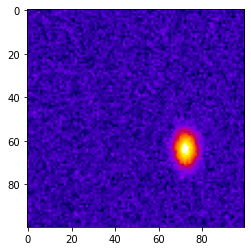

In [7]:
fig, ax = plt.subplots()
ax.imshow(mip, cmap=fire);

#### Estimate parameters

In [8]:
def guess_gaussian_2D_params(image):
    """Make initial estimates for a 2D Gaussian fit"""
    # Mask the central spot
    im = image.copy()
    hm = im < im.max()/2  # threshold at half-maximum
    im[hm] = 0
    xy = np.argwhere(im > 0)
    ys, xs = xy[:, 0], xy[:, 1]

    # Make estimates for x0, y0
    x0, y0 = xs.mean(), ys.mean()

    # Make estimates for sigma_x, sigma_y
    # sigma = FWHM / (2*sqrt(2*ln(2))) ~ FWHM / 2.355
    sigma_x = (xs.max() - xs.min()) / 2.355
    sigma_y = (ys.max() - ys.min()) / 2.355

    # Estimates for amplitude and background
    A = image.max()
    B = image.mean()

    return x0, y0, sigma_x, sigma_y, A, B

In [9]:
# Make estimates
p0 = guess_gaussian_2D_params(mip)

# Preview
out = f"""\
Initial estimates
-----------------
x0........ {p0[0]:.2f}
y0........ {p0[1]:.2f}
sigma_x... {p0[2]:.2f}
sigma_y... {p0[3]:.2f}
A......... {p0[4]:.2f}
B......... {p0[5]:.2f}
""";print(out)

Initial estimates
-----------------
x0........ 72.29
y0........ 63.74
sigma_x... 3.40
sigma_y... 5.10
A......... 1.29
B......... 0.16



#### 2D Fit

In [10]:
def _gaussian_2D(M, *args):
    """Wrapper for `gaussian_2D` to pass to `scipy.optimize.curve_fit`

    References
    ----------
    [1] https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/
    """
    # M = array([[ 0,  1,  2, ..., N-2, N-1, N], --> x
    #            [ 0,  0,  0, ..., N, N, N]])    --> y
    x, y = M
    return gaussian_2D(x, y, *args)

In [11]:
# Ravel the meshgrids of X, Y points to a pair of 1-D arrays
X = np.stack((xx.ravel(), yy.ravel()), axis=0)
# Ravel the image data
mip_1D = mip.ravel()

# Non-linear least squares to optimize fitting parameters
popt, pcov = curve_fit(_gaussian_2D, X, mip_1D, p0=p0)

# Preview
out = f"""\
Param  | Guess | Fit
-------------------------------
x0\t {p0[0]:.2f} \t {popt[0]:.2f}
y0\t {p0[1]:.2f} \t {popt[1]:.2f}
sigma_x\t {p0[2]:.2f} \t {popt[2]:.2f}
sigma_y\t {p0[3]:.2f} \t {popt[3]:.2f}
A\t {p0[4]:.2f} \t {popt[4]:.2f}
B\t {p0[5]:.2f} \t {popt[5]:.2f}
""";print(out)

Param  | Guess | Fit
-------------------------------
x0	 72.29 	 72.34
y0	 63.74 	 63.71
sigma_x	 3.40 	 3.41
sigma_y	 5.10 	 5.19
A	 1.29 	 1.11
B	 0.16 	 0.15



#### Comparison

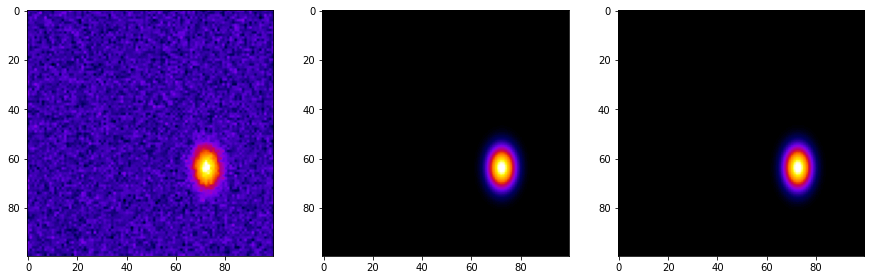

In [12]:
# 2D Gaussian based on initial estimates
guess = gaussian_2D(xx, yy, *p0)
# 2D Gaussian based on non-linear least squares estimate
fit = gaussian_2D(xx, yy, *popt)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
axes[0].imshow(mip, cmap=fire)
axes[1].imshow(guess, cmap=fire)
axes[2].imshow(fit, cmap=fire);

---
#### Batch

In [13]:
# Set up parameters
N = 10
Nx, Ny = 100, 100
x0 = np.random.uniform(0.2*Nx, 0.8*Nx, N)
y0 = np.random.uniform(0.2*Ny, 0.8*Ny, N)
sigma_x = np.random.uniform(Nx/30, Ny/10, N)
sigma_y = np.random.uniform(Ny/30, Ny/10, N)
A = np.random.uniform(1, 5, N)
B = np.random.uniform(0, 1, N)
var = np.random.uniform(0.001, 0.005, N)

# Initialize DataFrame
columns = ['x0', 'y0', 'sigma_x', 'sigma_y', 'A', 'B']
df_mip = pd.DataFrame(columns=columns)

# Generate N (fake) maximum intensity projection images
xx, yy = np.meshgrid(np.arange(Nx), np.arange(Ny))
mips = []
for i in range(N):
    # 2D Gaussian
    params = (x0[i], y0[i], sigma_x[i], sigma_y[i], A[i], B[i])
    G = gaussian_2D(xx, yy, *params)
    # Add noise
    mip = G + nonwhite_noise(var[i], (Ny, Nx))
    mips.append(mip)

    # Populate DataFrame
    df_mip.loc[i, columns] = params

#### Estimate

In [14]:
# Initialize DataFrame
df_guess = pd.DataFrame(columns=columns)
df_fit = pd.DataFrame(columns=columns)
# Collect guesses and fits
guesses = []
fits = []
for i in range(N):
    # Guess
    p0 = guess_gaussian_2D_params(mips[i])

    # Fit
    X = np.stack((xx.ravel(), yy.ravel()), axis=0)
    mip_1D = mips[i].ravel()
    popt, pcov = curve_fit(_gaussian_2D, X, mip_1D, p0=p0)

    # Compile
    guess = gaussian_2D(xx, yy, *p0)
    fit = gaussian_2D(xx, yy, *popt)
    guesses.append(guess)
    fits.append(fit)

    # Tabulate parameters
    df_guess.loc[i, columns] = p0
    df_fit.loc[i, columns] = popt

# Combine fitting data
df = pd.concat([df_mip, df_guess, df_fit], axis=1, keys=['mip', 'guess', 'fit'])\
       .sort_index(axis=1, level=1)
df.head()

,fit,guess,mip,fit,guess,mip,fit,guess,mip,fit,guess,mip,fit,guess,mip,fit,guess,mip
,A,A,A,B,B,B,sigma_x,sigma_x,sigma_x,sigma_y,sigma_y,sigma_y,x0,x0,x0,y0,y0,y0
0,4.404663,5.2961,4.40415,0.843562,0.92276,0.844411,5.3636,5.52017,5.378178,5.335497,5.52017,5.342363,72.500779,72.465839,72.50255,77.481791,77.52795,77.495672
1,2.055935,2.870596,2.05359,0.78178,0.833631,0.781402,8.745972,11.04034,8.791414,4.589453,5.52017,4.56008,36.564428,36.365517,36.544766,39.380705,39.393103,39.379115
2,4.60047,5.324469,4.607805,0.638543,0.727099,0.637227,5.860722,5.944798,5.852441,5.228568,5.52017,5.210428,78.945732,78.916129,78.955987,59.521945,59.541935,59.51608
3,3.218816,3.361152,3.220139,0.082485,0.211795,0.082935,7.102737,6.794055,7.106392,9.005617,8.917197,8.980011,49.792647,49.776173,49.798599,69.455606,69.509025,69.447416
4,1.566223,1.960097,1.558628,0.348015,0.382099,0.348231,6.35568,7.218684,6.468167,5.44947,6.369427,5.400851,66.516772,66.465,66.518045,35.836141,35.975,35.848503


#### Plot

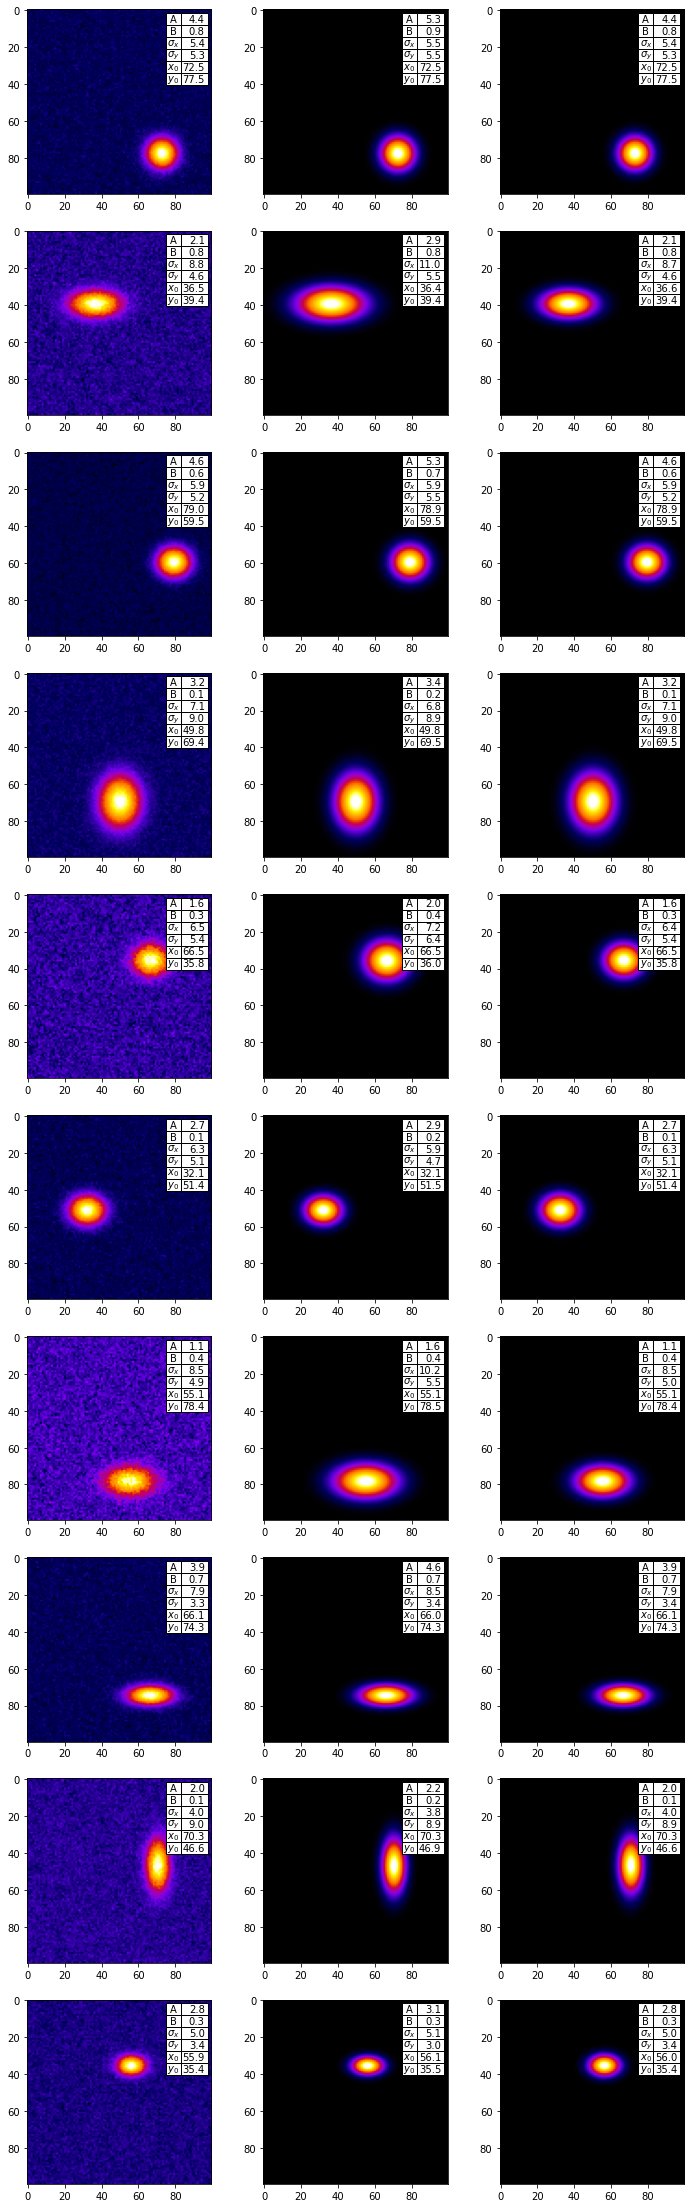

In [15]:
# Create figure
ncols = 3
nrows = N
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
for i in range(N):
    # Plot images
    axes[i,0].imshow(mips[i], cmap=fire)
    axes[i,1].imshow(guesses[i], cmap=fire)
    axes[i,2].imshow(fits[i], cmap=fire)

    # Plot tables
    df_m = pd.DataFrame(df.loc[i]['mip']).astype(float).round(1)
    df_g = pd.DataFrame(df.loc[i]['guess']).astype(float).round(1)
    df_f = pd.DataFrame(df.loc[i]['fit']).astype(float).round(1)
    rowLabels = ['A', 'B', '$\sigma_x$', '$\sigma_y$', '$x_0$', '$y_0$']
    tab_m = axes[i, 0].table(cellText=df_m.values, rowLabels=rowLabels,
                             rowLoc='center', loc='upper right', zorder=1)
    tab_g = axes[i, 1].table(cellText=df_g.values, rowLabels=rowLabels,
                             rowLoc='center', loc='upper right', zorder=1)
    tab_f = axes[i, 2].table(cellText=df_f.values, rowLabels=rowLabels,
                             rowLoc='center', loc='upper right', zorder=1)
    tab_m.auto_set_column_width(0)
    tab_g.auto_set_column_width(0)
    tab_f.auto_set_column_width(0)